In [1]:
import datasets
from random import shuffle
from math import ceil, log10

import torch
import torch.nn as nn

from transformers import AutoModel, AutoTokenizer
from tqdm.auto import tqdm

In [2]:
from collections import Counter
from datasets import Dataset

In [3]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split

In [5]:
FOL2NS = pd.read_json(
                "FOL2NS.json",
                orient="records",
                lines=True
                )

In [6]:
inputs = [[i] for i in FOL2NS["FOL2NS"]]
labels = torch.tensor([[j] for j in FOL2NS["QD"]])

In [7]:
Train, Dev = train_test_split(FOL2NS, test_size=0.2, random_state=42, shuffle=True)
x_train, y_train = Train['FOL2NS'].tolist(), Train['QD'].tolist()
x_dev, y_dev = Dev['FOL2NS'].tolist(), Dev['QD'].tolist()

In [8]:
class ClassificationHead(nn.Module):
    def __init__(self, model_dim=768, n_classes=4, dropout=0.2):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(model_dim, model_dim // 2)
        self.act     = nn.ReLU()
        self.linear2 = nn.Linear(model_dim // 2, n_classes)

    def forward(self, x):
        x = self.dropout(x)
        x = self.act(self.linear1(x))
        x = self.dropout(x)
        return self.linear2(x)

In [9]:
def process_batch(batch_inputs, batch_labels,
                  tokeniser, encoder, clf_head, 
                  optimiser, loss_fn, device):
    
    optimiser.zero_grad()
    tokenisation = tokeniser(batch_inputs,
                             padding="longest",
                             truncation=False,
                             return_tensors='pt').to(device)

    inputs = {k: v.to(device) for k, v in tokenisation.items()}
    outputs = encoder(**inputs).last_hidden_state ## (batch_size, seq_len, hidden_size)
#     cls = outputs.pooler_output
    cls_token_encodings = outputs[:, 0, :].to(device)
    logits = clf_head(cls_token_encodings)
    gold_labels = torch.tensor(batch_labels).to(device)
    loss = loss_fn(logits, gold_labels)
    loss.backward()
    optimiser.step()
    return loss.item()

In [10]:
def train_epoch(X_train, Y_train, tokeniser, encoder, clf_head, 
                optimiser, loss_fn, batch_size, device):
                       
    encoder.train()
    clf_head.train()
    n_steps = ceil(len(X_train)/batch_size)
    epoch_losses = torch.empty(n_steps)
    
    for step_n in tqdm(range(n_steps), desc='Train', leave=False): 
        lo = step_n * batch_size
        hi = lo + batch_size
        batch_texts = X_train[lo : hi]
        batch_labels = Y_train[lo : hi]
        loss = process_batch(batch_inputs=batch_texts, 
                             batch_labels=batch_labels,
                             tokeniser=tokeniser, 
                             encoder=encoder, 
                             clf_head=clf_head, 
                             optimiser=optimiser, 
                             loss_fn=loss_fn, 
                             device=device)
        
        epoch_losses[step_n] = loss
    
    return epoch_losses.mean().item() 

In [11]:
def validate_epoch(X_dev, Y_dev, tokeniser, encoder, clf_head, batch_size, device):
                       
    encoder.eval()
    clf_head.eval()
    all_preds, all_labels, all_logits = [], [], []
    n_steps = ceil(len(X_dev)/batch_size)
    epoch_losses = torch.empty(n_steps)
    epoch_accuracies = torch.empty(n_steps)
    
    for step_n in tqdm(range(n_steps), desc='Validate', leave=False): 
        lo = step_n * batch_size
        hi = lo + batch_size
        batch_texts = X_dev[lo : hi]
        batch_labels = torch.tensor(Y_dev[lo : hi])
        with torch.no_grad():
            tokenisation = tokeniser(batch_texts, return_tensors='pt', 
                                     padding='longest', truncation=False)
            inputs = {k: v.to(device) for k, v in tokenisation.items()}
            outputs = encoder(**inputs).last_hidden_state
            cls_token_encodings = outputs[:, 0, :].to(device)
            gold_labels = batch_labels.to(device)
            logits = clf_head(cls_token_encodings)
            
            loss = loss_fn(logits, gold_labels)
            epoch_losses[step_n] = loss.item()
            
            batch_preds = logits.argmax(dim=-1).flatten().cpu()
            all_preds.append(batch_preds)
            all_labels.append(batch_labels.cpu())
            all_logits.append(logits.cpu())
            epoch_accuracies[step_n] = (batch_labels.cpu()==batch_preds).sum().item() / batch_preds.size(0) 
            
    return epoch_losses.mean().item(), epoch_accuracies.mean().item(), all_preds, all_logits, all_labels

In [12]:
def main(X_train, Y_train, X_dev, Y_dev,
         tokeniser, encoder, clf_head, device, loss_fn,
         n_epochs, lr, early_stop, batch_size):
    
    optim = torch.optim.AdamW(list(encoder.parameters()) 
                            + list(clf_head.parameters()), lr=lr)
    
    lr_string = abs(int(log10(lr)))
    
    best_acc = 0.0
    last_improvement = 0
    train_losses = []
    dev_losses = []
    dev_accuracies = []
    dev_preds, dev_logits, dev_labels = [], [], []
    
    for epoch_n in tqdm(range(n_epochs)):
        
        train_loss = train_epoch(X_train=X_train, 
                                 Y_train=Y_train, 
                                 tokeniser=tokeniser, 
                                 encoder=encoder, 
                                 clf_head=clf_head, 
                                 optimiser=optim, 
                                 loss_fn=loss_fn, 
                                 batch_size=batch_size, 
                                 device=device)
        train_losses.append(train_loss)
        
        dev_loss, dev_acc, dev_pred, dev_logit, dev_label = validate_epoch(X_dev=X_dev, 
                                                                      Y_dev=Y_dev, 
                                                                      tokeniser=tokeniser, 
                                                                      encoder=encoder, 
                                                                      clf_head=clf_head, 
                                                                      batch_size=batch_size, 
                                                                      device=device)
        dev_losses.append(dev_loss)
        dev_accuracies.append(dev_acc)
        dev_preds.append(dev_pred)
        dev_logits.append(dev_logit)
        dev_labels.append(dev_label)

        print(f'Epoch {epoch_n+1}, train loss: {train_loss:.2f}; dev loss: {dev_loss:.2f}, dev acc: {dev_acc:.2f}')
        
        if dev_acc > best_acc:
            print('Saving the model')
            best_acc = dev_acc
            last_improvement = epoch_n

            for path in glob('*.pt'):
                os.remove(path)
            torch.save({'encoder': encoder.state_dict(),
                        'clf_head': clf_head.state_dict()}, 
                       f'BERT_QD_{epoch_n+1}_lr{lr_string}.pt')
        else:
            if epoch_n - last_improvement >= early_stop:
                print(f'Early stopping: no improvement for {early_stop} epochs.')
                break
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(dev_losses, label='Dev Loss')
    plt.plot(dev_accuracies, label='Dev Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, dev_losses, dev_accuracies, dev_preds, dev_logits, dev_labels

In [13]:
device = "cuda"
model_tag = 'google-bert/bert-base-uncased'
encoder = AutoModel.from_pretrained(model_tag).to(device)
tokeniser = AutoTokenizer.from_pretrained(model_tag)
clf_head = ClassificationHead(n_classes=4).to(device)
loss_fn = nn.CrossEntropyLoss()

In [14]:
torch.cuda.empty_cache() 

In [15]:
# validate_epoch(x_dev, y_dev, tokeniser, encoder, clf_head, batch_size=32, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Train:   0%|          | 0/79 [00:00<?, ?it/s]

Validate:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, train loss: 0.65; dev loss: 0.09, dev acc: 1.00
Saving the model


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Validate:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2, train loss: 0.07; dev loss: 0.02, dev acc: 1.00


Train:   0%|          | 0/79 [00:00<?, ?it/s]

Validate:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3, train loss: 0.03; dev loss: 0.01, dev acc: 1.00


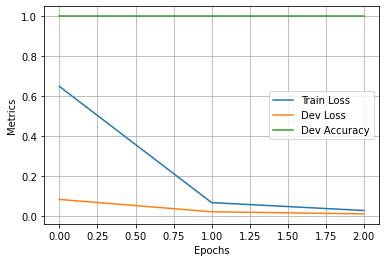

In [16]:
train_losses, dev_losses, dev_accuracies, dev_preds, dev_logits, dev_labels = main(x_train, y_train, x_dev, y_dev,
         tokeniser, encoder, clf_head, device, loss_fn,
         n_epochs=3, lr=10**(-5), early_stop=5, batch_size=32)

In [17]:
dev_logits # 0, 1, 2, 3

[[tensor([[-0.8309,  2.6553, -0.5638, -0.7375],
          [-0.8359,  2.6658, -0.5823, -0.7297],
          [-0.8369,  2.6708, -0.6023, -0.7358],
          [-1.2165, -1.5278, -0.8256,  2.5129],
          [-1.1101, -1.3754, -1.0310,  2.5429],
          [-0.7853,  2.6508, -0.6287, -0.7246],
          [-1.2785, -0.6843,  2.8140, -0.5201],
          [-1.3262, -0.6261,  2.8415, -0.5109],
          [-1.1600, -1.4507, -1.0646,  2.5599],
          [-1.3884, -0.6442,  2.7723, -0.4304],
          [-1.4000, -0.7278,  2.8377, -0.5465],
          [-0.7033,  2.6121, -0.7314, -0.6833],
          [-1.4895, -0.5112,  2.7954, -0.5613],
          [-1.0782, -1.4635, -1.0881,  2.5610],
          [-1.4080, -0.4068,  2.7730, -0.7255],
          [-1.3158, -0.8973,  2.8133, -0.3996],
          [-0.8058,  2.6519, -0.6220, -0.7123],
          [-0.8398,  2.6383, -0.5558, -0.7592],
          [-1.1229, -1.4463, -1.0976,  2.5945],
          [-0.7876,  2.6545, -0.6442, -0.6909],
          [-1.4102, -0.5475,  2.8170, -0

In [18]:
dev_preds

[[tensor([1, 1, 1, 3, 3, 1, 2, 2, 3, 2, 2, 1, 2, 3, 2, 2, 1, 1, 3, 1, 2, 2, 1, 3,
          1, 2, 3, 2, 3, 3, 2, 1]),
  tensor([2, 1, 2, 1, 1, 3, 2, 1, 3, 2, 3, 3, 3, 3, 3, 1, 1, 1, 2, 1, 2, 2, 3, 3,
          1, 1, 3, 1, 1, 1, 1, 3]),
  tensor([3, 2, 3, 1, 3, 2, 2, 2, 1, 2, 1, 2, 1, 3, 2, 2, 2, 3, 1, 1, 2, 3, 2, 2,
          2, 1, 2, 2, 1, 3, 3, 1]),
  tensor([2, 3, 3, 1, 1, 1, 3, 1, 3, 2, 3, 2, 2, 1, 1, 1, 2, 3, 3, 1, 1, 1, 2, 1,
          1, 3, 2, 1, 1, 1, 3, 3]),
  tensor([1, 3, 3, 2, 3, 2, 2, 1, 1, 3, 3, 3, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1,
          1, 3, 3, 2, 2, 2, 3, 3]),
  tensor([1, 3, 2, 2, 2, 1, 1, 3, 1, 1, 2, 2, 3, 3, 1, 3, 3, 3, 1, 2, 1, 1, 3, 2,
          3, 1, 2, 1, 2, 1, 3, 3]),
  tensor([3, 1, 3, 2, 2, 1, 2, 2, 1, 1, 3, 2, 3, 1, 1, 3, 3, 1, 1, 1, 2, 3, 1, 2,
          2, 1, 3, 2, 2, 2, 1, 3]),
  tensor([2, 1, 2, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3, 2, 2, 3, 1, 1, 2, 2, 1, 2, 2,
          3, 1, 3, 1, 1, 2, 3, 2]),
  tensor([3, 3, 3, 1, 2, 1, 1, 3, 1, 1, 2, 1, 2, 1, 1, 3

In [19]:
dev_labels

[[tensor([1, 1, 1, 3, 3, 1, 2, 2, 3, 2, 2, 1, 2, 3, 2, 2, 1, 1, 3, 1, 2, 2, 1, 3,
          1, 2, 3, 2, 3, 3, 2, 1]),
  tensor([2, 1, 2, 1, 1, 3, 2, 1, 3, 2, 3, 3, 3, 3, 3, 1, 1, 1, 2, 1, 2, 2, 3, 3,
          1, 1, 3, 1, 1, 1, 1, 3]),
  tensor([3, 2, 3, 1, 3, 2, 2, 2, 1, 2, 1, 2, 1, 3, 2, 2, 2, 3, 1, 1, 2, 3, 2, 2,
          2, 1, 2, 2, 1, 3, 3, 1]),
  tensor([2, 3, 3, 1, 1, 1, 3, 1, 3, 2, 3, 2, 2, 1, 1, 1, 2, 3, 3, 1, 1, 1, 2, 1,
          1, 3, 2, 1, 1, 1, 3, 3]),
  tensor([1, 3, 3, 2, 3, 2, 2, 1, 1, 3, 3, 3, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1,
          1, 3, 3, 2, 2, 2, 3, 3]),
  tensor([1, 3, 2, 2, 2, 1, 1, 3, 1, 1, 2, 2, 3, 3, 1, 3, 3, 3, 1, 2, 1, 1, 3, 2,
          3, 1, 2, 1, 2, 1, 3, 3]),
  tensor([3, 1, 3, 2, 2, 1, 2, 2, 1, 1, 3, 2, 3, 1, 1, 3, 3, 1, 1, 1, 2, 3, 1, 2,
          2, 1, 3, 2, 2, 2, 1, 3]),
  tensor([2, 1, 2, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3, 2, 2, 3, 1, 1, 2, 2, 1, 2, 2,
          3, 1, 3, 1, 1, 2, 3, 2]),
  tensor([3, 3, 3, 1, 2, 1, 1, 3, 1, 1, 2, 1, 2, 1, 1, 3